In [1]:
import numpy as np
import h5py
from scipy.io import loadmat

from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from sklearn import metrics

import matplotlib.pyplot as plt
from ipywidgets import interact
% matplotlib inline

/Users/elyall/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
Dir = '/Users/elyall/Dropbox/Data/'
# Dir = '/media/elyall/Data/7737/180118/'
filebase = Dir + '7737_291_000'
# depth = 1;

expfile = filebase + '.exp'
fn = filebase + '.rois'
# fn = filebase + "_%01d" % depth + '.rois'
print(expfile)
print(fn)

number_of_neurons = np.logspace(0,2.4,13).round().astype('int') # list of number of neurons to sample
niter = 5      # number of replicates for N samples
nfolds = 5     # cross-validation
max_iter = 100 # regression convergence

print(number_of_neurons)

/Users/elyall/Dropbox/Data/7737_291_000.exp
/Users/elyall/Dropbox/Data/7737_291_000.rois
[  1   2   3   4   6  10  16  25  40  63 100 158 251]


In [127]:
# Load StimID
myfile = h5py.File(expfile,'r')
StimID = myfle['/TrialInfo/StimID'].value[:]
TrialIndex = myfile['TrialIndex'].value[:]
myfile.close()

# Load data
myfile = h5py.File(fn,'r')
numNeurons = len(myfile['ROIdata/rois/stimMean'])
numTrials = len(myfile['ROIdata/DataInfo/StimID'][0])
data = np.zeros([numTrials,numNeurons])
for n in np.arange(numNeurons):
    data[:,n] = myfile[myfile['ROIdata/rois/stimMean'][n][0]].value
myfile.close()
data = data[TrialIndex,:] # keep only desired trials

# data = np.random.random([np.size(TrialIndex),100]) # fake data

In [55]:
# Compute logistic regression

numTrials, numNeurons = np.shape(data)
numX = np.size(number_of_neurons)

pred = np.zeros([numTrials,niter,numX])
perc_correct = np.zeros([niter,numX])

for n, N in enumerate(number_of_neurons):
    
    for ind in np.arange(niter):

        # pull out sample of neurons
        my_sample = np.random.choice(range(numNeurons), N)
        current = data[:,my_sample]

        # fit Logistic Regression to random sample (using KFold cross-validation)
        skf = StratifiedKFold(n_splits=nfolds)
        for train_index, test_index in skf.split(current, StimID):
            X_train, X_test = current[train_index,:], current[test_index,:]
            y_train, y_test = StimID[train_index], StimID[test_index]

            logreg = linear_model.LogisticRegression(max_iter=max_iter,solver='sag',multi_class='multinomial')

            logreg.fit(X_train, np.ravel(y_train))

            pred[test_index,ind,n] = logreg.predict(X_test)

        perc_correct[ind,n] = metrics.accuracy_score(StimID, pred[:,ind,n])
#         confusion_matrix = metrics.confusion_matrix(StimID, pred[:,ind,n])


/Users/elyall/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Text(0.5,0,'# of Neurons')

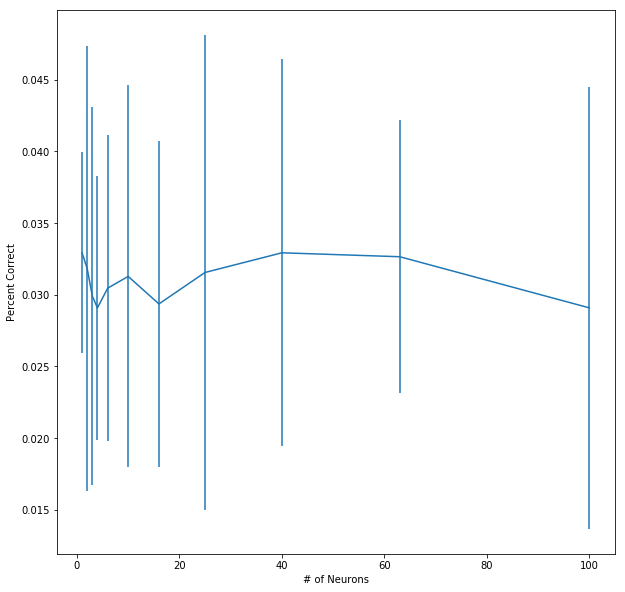

In [74]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.errorbar(number_of_neurons,np.mean(perc_correct,axis=0),yerr=1.96*np.std(perc_correct,axis=0))
ax.set_ylabel('Percent Correct')
ax.set_xlabel('# of Neurons')